# Combo Modeling
An introduction to the native ensemble/combo model in scalecast.  

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
from scalecast.Forecaster import Forecaster
from scalecast.SeriesTransformer import SeriesTransformer
from scalecast.Pipeline import Transformer, Reverter
from scalecast import GridGenerator

Download data from FRED (https://fred.stlouisfed.org/series/HOUSTNSA). This data is interesting due to its strong seasonality and irregular cycles. It measures monthly housing starts in the USA since 1959. Predicting this metric with some series that measures demand for houses could be an interesting extension to be able to explain housing prices. It is a common example series that scalecast uses.

In [2]:
GridGenerator.get_example_grids()
df = pdr.get_data_fred('HOUSTNSA',start='1900-01-01',end='2022-12-31')
f = Forecaster(
    y=df['HOUSTNSA'],
    current_dates=df.index,
    future_dates = 24,
    test_length = .1,
)
f

Forecaster(
    DateStartActuals=1959-01-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=768
    ForecastLength=24
    Xvars=[]
    Differenced=0
    TestLength=76
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

## Preprocess Data
- Difference, seasonal difference, and scale the data.
- Create the object that will revert these transformations.

In [3]:
# create transformations to model stationary data
transformer = Transformer(
    transformers = [
        ('DiffTransform',1),
        ('DiffTransform',12),
        ('MinMaxTransform',),
    ]
)

reverter = Reverter(
    reverters = [
        ('MinMaxRevert',),
        ('DiffRevert',12),
        ('DiffRevert',1)
    ],
    base_transformer = transformer,
)

reverter

Reverter(
  reverters = [
    ('MinMaxRevert',),
    ('DiffRevert', 12),
    ('DiffRevert', 1)
  ],
  base_transformer = Transformer(
  transformers = [
    ('DiffTransform', 1),
    ('DiffTransform', 12),
    ('MinMaxTransform',)
  ]
)
)

In [4]:
# transform the series by calling the Transformer.fit_transform() method
f = transformer.fit_transform(f)

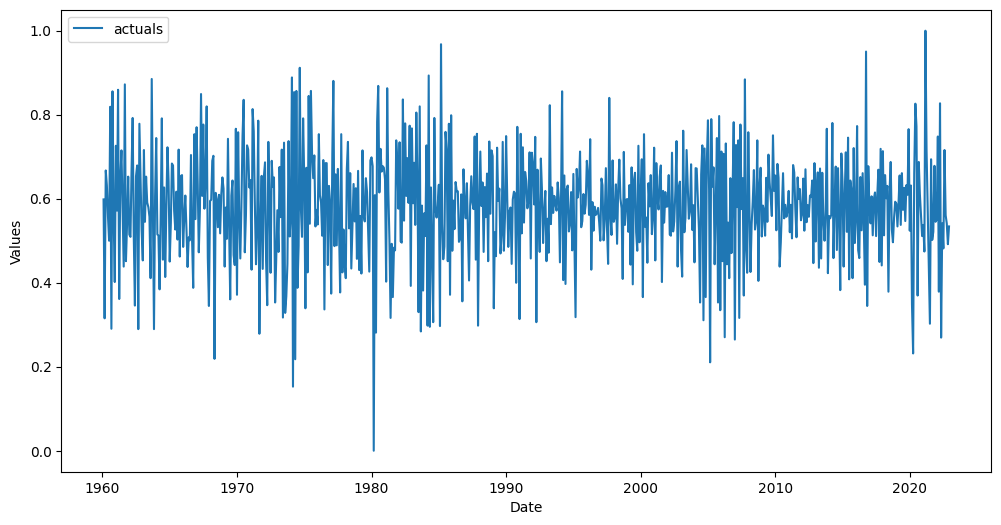

In [5]:
# plot the results
f.plot();

In [6]:
# add regressors
f.add_ar_terms(24)
f

Forecaster(
    DateStartActuals=1960-02-01T00:00:00.000000000
    DateEndActuals=2022-12-01T00:00:00.000000000
    Freq=MS
    N_actuals=755
    ForecastLength=24
    Xvars=['AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24']
    Differenced=0
    TestLength=76
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    BootstrapSamples=100
    CurrentEstimator=None
    GridsFile=Grids
)

## Evaluate Forecasting models

In [7]:
# evaluate some models
f.tune_test_forecast(
    [
        'elasticnet',
        'lasso',
        'ridge',
        'gbt',
        'lightgbm',
        'xgboost',
    ],
    dynamic_testing = 24,
    limit_grid_size = .2,
)

## Combine Evaluated Models
- Below, we see several combination options that scalecast offers. These are just examples and not meant to try to find the absolute best combination for the data.

In [8]:
f.set_estimator('combo')
# simple average of all models
f.manual_forecast(call_me = 'avg_all')
# weighted average of all models where the weights are determined from validation (not test) performance
f.manual_forecast(
    how = 'weighted', 
    determine_best_by = 'ValidationMetricValue', 
    call_me = 'weighted_avg_all',
)
# simple average of a select set of models
f.manual_forecast(models = ['xgboost','gbt','lightgbm'],call_me = 'avg_trees')
# weighted average of a select set of models where the weights are determined from validation (not test) performance
f.manual_forecast(models = ['elasticnet','lasso','ridge'],call_me = 'avg_lms')
# weighted average of a select set of models where the weights are manually passed 
# weights do not have to add to 1 and they will be rebalanced to do so
f.manual_forecast(
    how = 'weighted', 
    models = ['xgboost','elasticnet','lightgbm'], 
    weights = (3,2,1), 
    determine_best_by = None, 
    call_me = 'weighted_avg_manual',
)
# splice (not many other libraries do this) - splice the future point forecasts of two or more models together
f.manual_forecast(
    how='splice',
    models = ['elasticnet','lightgbm'],
    splice_points = ['2023-01-01'],
    call_me = 'splice',
)

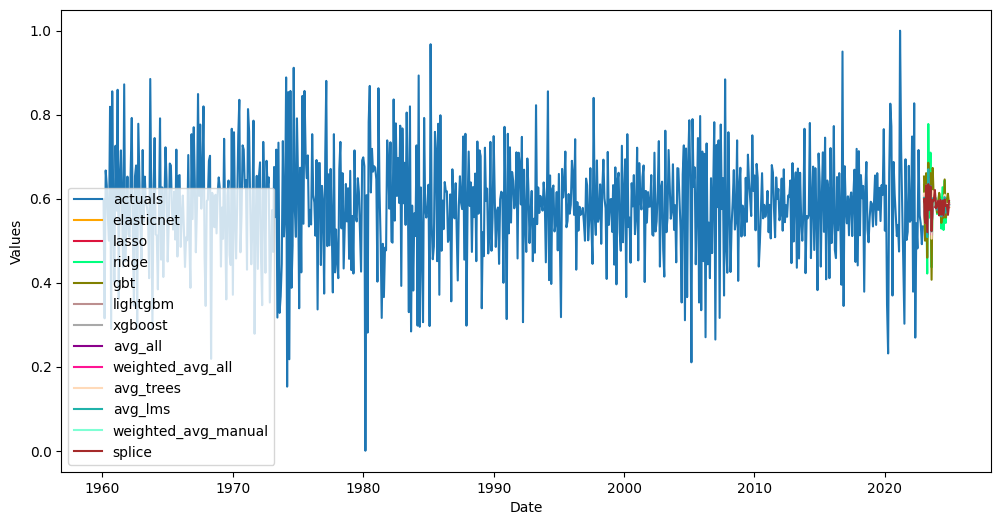

In [9]:
# plot the forecasts at the series' transformed level
f.plot();

In [10]:
# revert the transformation
f = reverter.fit_transform(f)

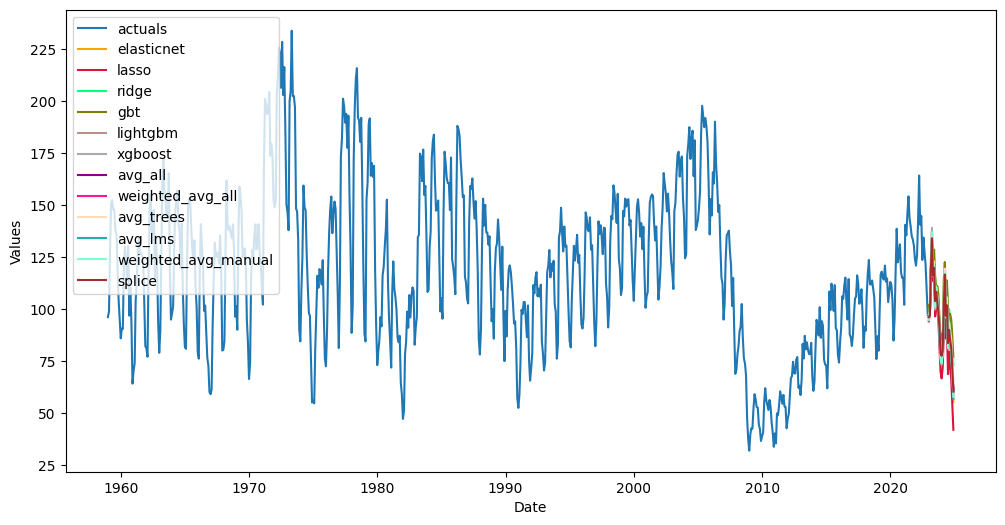

In [11]:
# plot the forecasts at the series' original level
f.plot();

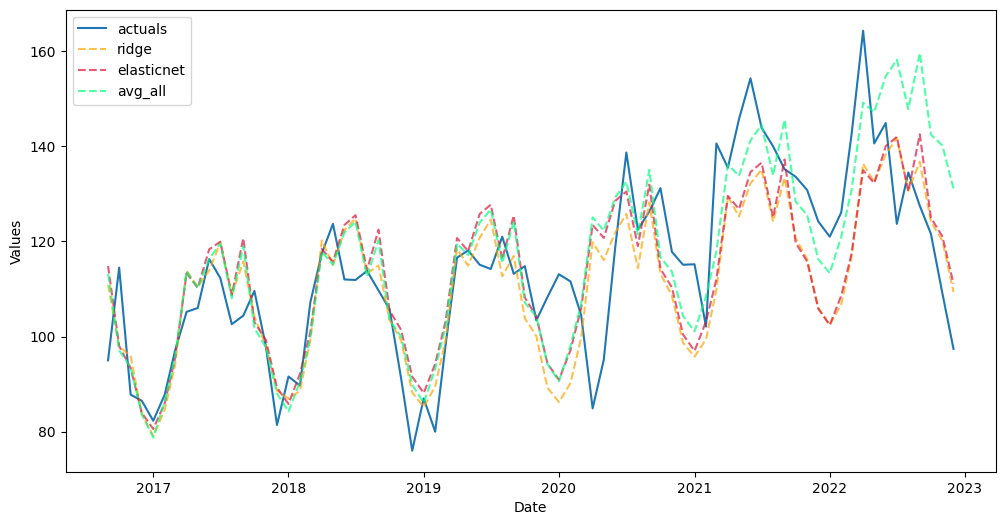

In [12]:
# view performance on test set
f.plot_test_set(models = 'top_3',order_by = 'TestSetRMSE',include_train = False);